Universidade Federal de Alagoas

IC - Instituto de Computação

 

# Processamento de linguagem natural - 2020.1
**Professor**: Thales Vieira

**Alunos**: Hugo Tallys Martins Oliveira e Valério Nogueira Rodrigues Júnior


## 4ª lista de exercícios

---

# Pré-processamento dos dados

In [ ]:
!pip install -U yellowbrick

In [ ]:
import re
import time
import umap
import nltk
import numpy
import pandas

from bokeh.plotting import figure
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from bokeh.palettes import Category20
from sklearn.decomposition import PCA
from IPython.display import HTML, display
from bokeh.io import output_notebook, show
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [3]:
output_notebook() # Necessário para visualizar os gráficos com bokeh

In [ ]:
nltk.download('stopwords'); nltk.download('rslp'); nltk.download('punkt');

In [5]:
bbc_dataset_url = 'https://raw.githubusercontent.com/valeriojr/ecom063-pln/master/data/bbc.csv'
cnn_dataset_url = 'https://raw.githubusercontent.com/valeriojr/ecom063-pln/master/data/cnn.csv'

dataset = pandas.concat([pandas.read_csv(dataset_url, sep='|') for dataset_url in [bbc_dataset_url, cnn_dataset_url]], ignore_index=True)
dataset = dataset.dropna(axis=0).reset_index(drop=True)

In [6]:
dataset.text = dataset.text.apply(lambda text: text.replace('\n', ' ')) # Remoção das quebras de linha

In [7]:
def remove_boilerplate(text):
    boilerplate = ['Compartilhe este post com Email Facebook Messenger Messenger Twitter WhatsApp LinkedIn Copiar este link Estes são links externos e abrirão numa nova janela', 'Já assistiu aos nossos novos vídeos no YouTube? Inscreva-se no nosso canal!', 'Final de YouTube post  de BBC News Brasil Final de YouTube post 2 de BBC News Brasil Final de YouTube post 3 de BBC News Brasil']
    
    for b in boilerplate:
      text = text.replace(b, '')

    return text

dataset.text = dataset.text.apply(remove_boilerplate) # Remoção de fragmentos irrelevantes do texto que se repetem

In [8]:
def preprocess(text):
  text = re.sub(r'\w*\d\w*', '', text) # Remove todas as palavras que contém números
  text = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ ]', '', text.lower()) # Remove pontuação e converte para minúscula
  return re.sub(r'\s+', ' ', text) # Remove espaços repetidos

dataset['processed_text'] = dataset.text.apply(preprocess)

In [9]:
stopwords = nltk.corpus.stopwords.words('portuguese')

def tokenize_remove_stopwords(text):
  tokenized_text = nltk.word_tokenize(text, language='portuguese')
  return " ".join([token for token in tokenized_text if token not in stopwords])

dataset.processed_text = dataset.processed_text.apply(tokenize_remove_stopwords) # Tokeniza o texto e remove stopwords

In [10]:
dataset

,url,title,text,processed_text
0,https://www.bbc.co.uk/portuguese/brasil-53020785,Coronavírus: pandemia pode jogar até 14 milhõe...,A turbulência econômica causada pela pandemi...,turbulência econômica causada pandemia novo co...
1,https://www.bbc.co.uk/portuguese/brasil-53027318,Coronavírus: como funcionam as duas vacinas co...,Cerca de 11 mil voluntários brasileiros vão ...,cerca mil voluntários brasileiros vão receber ...
2,https://www.bbc.co.uk/portuguese/brasil-51713943,Coronavírus: Brasil passa o Reino Unido e se t...,*atualizada às 18h20 de 12 de junho de 2020 ...,atualizada s junho brasil totalizou nesta sext...
3,https://www.bbc.co.uk/portuguese/internacional...,Coronavírus na Índia: com lockdown 'insustentá...,"Quando, em 24 de março, o governo indiano in...",março governo indiano iniciou estrito isolamen...
4,https://www.bbc.co.uk/portuguese/internacional...,2ª onda do coronavírus? Irã vê aumento acelera...,O Irã registrou um rápido aumento no número ...,irã registrou rápido aumento número casos covi...
...,...,...,...,...
1611,https://www.cnnbrasil.com.br/saude/2020/02/27/...,Farmácias têm falta de máscaras após confirmaç...,Com a confirmação do primeiro caso de contamin...,confirmação primeiro caso contaminação novo co...
1612,https://www.cnnbrasil.com.br/business/2020/02/...,Ibovespa tem nova queda com mercado ainda preo...,Preocupações com a propagação do novo coronaví...,preocupações propagação novo coronavírus poten...
1613,https://www.cnnbrasil.com.br/internacional/202...,Japonesa testa positivo pela segunda vez para ...,TÓQUIO - Uma guia de ônibus turístico no Japão...,tóquio guia ônibus turístico japão apresentou ...
1614,https://www.cnnbrasil.com.br/saude/2020/02/26/...,Primeiro brasileiro com coronavírus tem sintom...,O primeiro brasileiro com diagnóstico confir...,primeiro brasileiro diagnóstico confirmado cor...


# Modelagem de tópicos

Comparativo entre métodos _LDA_, _SVD_ e _NMF_ para realizar modelagem de tópicos:

* empiricamente, tentar identificar uma quantidade de tópicos adequada para
seu problema;
* identificar as 5 palavras mais relevantes de cada tópico;
* identificar os 3 tópicos mais relevantes de 5 documentos quaisquer.

In [11]:
n_topics=5
samples = dataset.sample(n=5)
samples.reset_index(inplace=True)
samples

,index,url,title,text,processed_text
0,123,https://www.bbc.co.uk/portuguese/internacional...,Coronavírus: casa de repouso na Holanda reúne ...,Um lar para idosos na Holanda vem proporcionan...,lar idosos holanda vem proporcionando moradore...
1,186,https://www.bbc.co.uk/portuguese/geral-52389645,Coronavírus pode ser só 'ensaio' de uma próxim...,A crise gerada pelo novo coronavírus mudou p...,crise gerada novo coronavírus mudou profundame...
2,415,https://www.cnnbrasil.com.br/saude/2020/05/20/...,"Coronavírus supera câncer e enfarte; por dia, ...","Com a marca de 1,1 mil mortes nesta terça-feir...",marca mil mortes nesta terçafeira pandemia nov...
3,462,https://www.cnnbrasil.com.br/internacional/202...,França encontra caso de contaminação por coron...,"""A identificação do primeiro paciente infectad...",identificação primeiro paciente infectado gran...
4,766,https://www.cnnbrasil.com.br/business/2020/04/...,Casos de coronavírus chegam a 1 mi e ações asi...,As ações de Xangai fecharam em queda nesta sex...,ações xangai fecharam queda nesta sextafeira c...


Utilizando __TF-IDF__ como _embbeding_ dos textos:

In [12]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(dataset.processed_text)

In [13]:
for decomposition_algorithm in (LatentDirichletAllocation, TruncatedSVD, NMF):
    algorithm = decomposition_algorithm(n_components=n_topics)
    X_topics = algorithm.fit_transform(X)
    
    def get_top_words(topic, n, words, algorithm):
        sorted_idxs = numpy.argsort(algorithm.components_[topic])
        top_words = [words[i] for i in sorted_idxs]
        return [w for w in reversed(top_words[-n:])]
    
    print(f'Algoritmo: {decomposition_algorithm.__name__}')
    for i in range(n_topics):
        print(f'Tópico {i} -> {get_top_words(i, 5, vectorizer.get_feature_names(), algorithm)}')
    print('\n')

    sample_topics = algorithm.transform(vectorizer.transform(samples.processed_text))

    for i, sample in samples.iterrows():
        print(f'{sample.title} - {sample.url}')
        print(sample.text[:70] + '...')
        print(sample_topics[i])
        print('\n')

Algoritmo: LatentDirichletAllocation
Tópico 0 -> ['casos', 'coronavírus', 'saúde', 'pessoas', 'brasil']
Tópico 1 -> ['sanz', 'shimura', 'comediante', 'jett', 'comédia']
Tópico 2 -> ['junqueira', 'caio', 'assista', 'análise', 'opep']
Tópico 3 -> ['iuri', 'pitta', 'assista', 'análise', 'molica']
Tópico 4 -> ['ssec', 'nikkei', 'seng', 'taiex', 'spasx']


Coronavírus: casa de repouso na Holanda reúne moradores com familiares em cabines de vidro - BBC News Brasil - https://www.bbc.co.uk/portuguese/internacional-52670929
Um lar para idosos na Holanda vem proporcionando a seus moradores a ch...
[0.92307531 0.01923124 0.01923113 0.01923118 0.01923114]


Coronavírus pode ser só 'ensaio' de uma próxima grande pandemia, diz médico e matemático da USP - BBC News Brasil - https://www.bbc.co.uk/portuguese/geral-52389645
  A crise gerada pelo novo coronavírus mudou profundamente o modo de v...
[0.95462247 0.01134433 0.01134477 0.01134423 0.0113442 ]


Coronavírus supera câncer e enfarte; por dia, já 

Melhor algoritmo: __NMF__ 

In [14]:
dataset['sorted_topics'] = [x for x in numpy.argsort(X_topics, axis=1)]

# Agrupamento

Realizar um agrupamento dos dados através das seguintes etapas:

* Aplicar o algotimo __PCA__ preservando _95%_ da variância nos dados
* Aplicar o algoritmo ___k_-means__ nos dados projetados, utilizando o método _elbow_ para encontrar o valor de _k_ ótimo

Vamos realizar _stemming_ no texto pré-processado e vetorizar o resultado:

In [15]:
stemmer = nltk.stem.RSLPStemmer()
dataset['stemmed_text'] = dataset.processed_text.apply(lambda tokens: ' '.join([stemmer.stem(token) for token in tokens.split(' ')]))
X = vectorizer.fit_transform(dataset.stemmed_text)

In [16]:
X_proj = PCA(n_components=.95).fit_transform(X.toarray())

Dimensão dos pontos projetados: 

In [17]:
X_proj.shape[1]

1236

Plotando o gráfico da distorção:

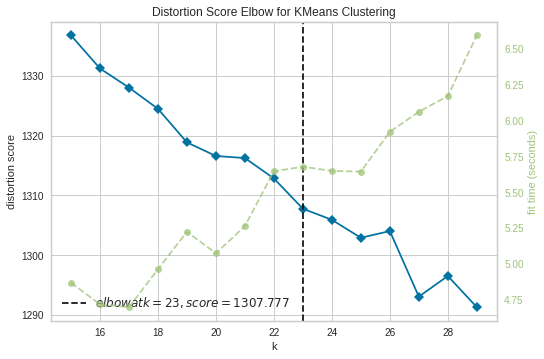

In [18]:
visualizer = KElbowVisualizer(KMeans(), k=(15, 30), metric='distortion')
visualizer.fit(X_proj)
visualizer.show() 

Observando o gráfico acima escolhemos $k=20$

In [19]:
k = 20
kmeans = KMeans(n_clusters=k).fit(X_proj)

Projetando os pontos no espaço de visualização via __TSNE__:

In [20]:
start_time = time.time()
X_tsne = TSNE(n_components=2).fit_transform(X_proj)
interval_time = time.time() - start_time

Tempo de execução:

In [21]:
print('%s segundos' % interval_time)

20.933223009109497 segundos


Gráfico de dispersão dos pontos:

In [22]:
color_palette = Category20[k]

In [23]:
def scatter_plot(X, labels):
  scatter_plot = figure(plot_width=1000, plot_height=500)
  scatter_plot.circle(X[:, 0], X[:, 1], size=10, line_color=[color_palette[l] for l in labels], fill_color=[color_palette[l] for l in labels], fill_alpha=.8)
  show(scatter_plot)

scatter_plot(X_tsne, kmeans.labels_)

Projetando os pontos no espaço de visualização via __UMAP__:

In [24]:
start_time = time.time()
X_umap = umap.UMAP().fit_transform(X_proj)
interval_time = time.time() - start_time

Tempo de execução:

In [25]:
print('%s segundos' % interval_time)

12.017657995223999 segundos


In [26]:
scatter_plot(X_umap, kmeans.labels_)

Agora vamos descobrir as palavras mais relevantes de cada grupo (considerando um único tópico em cada grupo):

In [27]:
dataset['label'] = kmeans.labels_

In [28]:
def cluster_topic(dataset, cluster_label, n_words):
  X = vectorizer.fit_transform(dataset[dataset['label'] == cluster_label].processed_text)
  nmf = NMF(n_components=1)
  X_topics = nmf.fit_transform(X)
  return get_top_words(0, n_words, vectorizer.get_feature_names(), nmf)

In [29]:
n_words = 10
display(HTML('<h2>Top {} palavras de cada grupo</h2>'.format(n_words)))
for label, color in enumerate(color_palette):
  display(HTML('<h3><span style="color:{}"><strong>Grupo {}: {}</strong></span></h3>'.format(color, label, ', '.join(cluster_topic(dataset, label, n_words)))))